In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('seaborn-notebook')
%matplotlib inline

# 前向传播和反向传播

## 前向传播

- 假设输入样本是 $\mathbf{x}\in \mathbb{R}^d$，并且隐藏层不包括偏置项，中间变量是：

$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x},$$

其中$\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$

- 得到长度为$h$的隐藏激活向量：

$$\mathbf{h}= \phi (\mathbf{z}).$$

- 假设输出层的参数只有权重$\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$，可以得到输出层变量是一个长度为$q$的向量：

$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

- 假设损失函数为$l$，样本标签为$y$，可以计算单个数据样本的损失项，

$$L = l(\mathbf{o}, y).$$

- 给定超参数$\lambda$，$L_2$正则化项为

$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_F^2 + \|\mathbf{W}^{(2)}\|_F^2\right)$$

其中矩阵的Frobenius范数是将矩阵展平为向量后应用的$L_2$范数

- 模型在给定数据样本上的正则化损失为：

$$J = L + s.$$

- 前向传播计算图
    - 正方形表示变量，圆圈表示操作符

<center><img src="../img/4_multilayer-perceptrons/forward.svg" width=100%></center>

## 反向传播

- 根据微积分中的*链式规则*，按相反的顺序从输出层到输入层遍历网络
- 该算法存储了计算某些参数梯度时所需的任何中间变量（偏导数）

- 假设有函数$\mathsf{Y}=f(\mathsf{X})$和$\mathsf{Z}=g(\mathsf{Y})$，其中输入和输出$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$是任意形状的张量。
- 利用链式法则，可以计算$\mathsf{Z}$关于$\mathsf{X}$的导数

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

其中，$\text{prod}$运算符在执行必要的操作（如换位和交换输入位置）后将其参数相乘

- 反向传播的目的是计算梯度：
    - $\partial J/\partial \mathbf{W}^{(1)}$
    - $\partial J/\partial \mathbf{W}^{(2)}$

- 从计算图的结果开始，并朝着参数的方向努力。第一步是计算目标函数$J=L+s$相对于损失项$L$和正则项$s$的梯度。

$$\frac{\partial J}{\partial L} = 1 \; \text{和} \; \frac{\partial J}{\partial s} = 1.$$

- 根据链式法则计算目标函数关于输出层变量$\mathbf{o}$的梯度：

$$
\frac{\partial J}{\partial \mathbf{o}}
= \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q.
$$

- 接下来，计算正则化项相对于两个参数的梯度：

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\; \text{和} \;
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$

- 现在可以计算最接近输出层的模型参数的梯度 $\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$。

$$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.$$

- 为了获得关于$\mathbf{W}^{(1)}$的梯度，需要继续沿着输出层到隐藏层反向传播。关于隐藏层输出的梯度$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$由下式给出：

$$
\frac{\partial J}{\partial \mathbf{h}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$

- 由于激活函数$\phi$是按元素计算的，计算中间变量$\mathbf{z}$的梯度$\partial J/\partial \mathbf{z} \in \mathbb{R}^h$
需要使用按元素乘法运算符，用$\odot$表示：

$$
\frac{\partial J}{\partial \mathbf{z}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$

- 最后，可以得到最接近输入层的模型参数的梯度$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$。根据链式法则，得到：

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$

# 数值稳定性和模型初始化

- 初始化方案的选择在神经网络学习中对保持数值稳定性至关重要

- 初始化方案的选择与非线性激活函数的选择搭配，可以决定优化算法收敛的速度

- 糟糕选择可能会导致在训练时遇到**梯度消失**或**梯度爆炸**

考虑一个具有$L$层、输入$\mathbf{x}$和输出$\mathbf{o}$的深层网络。
每一层$l$由变换$f_l$定义，
该变换的参数为权重$\mathbf{W}^{(l)}$，
其隐藏变量是$\mathbf{h}^{(l)}$（令 $\mathbf{h}^{(0)} = \mathbf{x}$）。

网络可以表示为：

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ 因此 } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x})$$

如果所有隐藏变量和输入都是向量，
可以将$\mathbf{o}$关于任何一组参数$\mathbf{W}^{(l)}$的梯度写为下式：

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}$$

- 该梯度是$L-l$个矩阵
$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$
与梯度向量 $\mathbf{v}^{(l)}$的乘积

- 当将太多的概率乘在一起时，值可能非常小，也可能非常大

## 梯度消失

\begin{definition}\label{def:gradientVanishing}
**梯度消失**（gradient vanishing）：
参数更新过小，在每次更新时几乎不会移动，导致模型无法学习
\end{definition}


- sigmoid函数是导致梯度消失问题的一个常见的原因

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

In [3]:
import sys
sys.path.append('/home/teaching/slides/deeplearning/') 
from classAndFunctions import plot

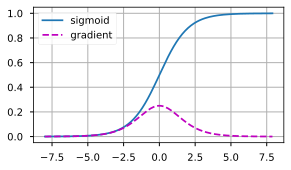

In [4]:
plot(x.detach().numpy(),[y.detach().numpy(),x.grad.numpy()],legend=['sigmoid','gradient'],figsize=(4.5,2.5))

- 当sigmoid函数的输入很大或是很小时，它的梯度都会消失

- 当网络有很多层时，除非很小心，否则在某一层可能会切断梯度

- 因此，更稳定的**ReLU系列函数**已经成为从业者的默认选择

## 梯度爆炸

\begin{definition}\label{def:gradientExploding}
**梯度爆炸**（gradient exploding）：
参数更新过大，破坏了模型的稳定收敛
\end{definition}


生成100个高斯随机矩阵，并将它们与某个初始矩阵相乘

In [12]:
M = torch.normal(0, 1, size=(4,4))   # 均值为0，标准差为1 的正态分布矩阵
print(f'一个矩阵 \n{M}')

一个矩阵 
tensor([[-0.2476,  0.0529, -1.9385,  1.8097],
        [ 2.4856, -0.5612, -0.9444, -0.1306],
        [-0.3567, -0.6663,  0.1778, -0.2746],
        [-0.7519, -0.5869,  0.3779,  1.4669]])


In [13]:
for i in range(100):
    # 生成100个矩阵，并相乘
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print(f'乘以100个矩阵后\n{M}')

乘以100个矩阵后
tensor([[ 7.6970e+23,  2.2630e+24, -1.2109e+25, -2.3631e+24],
        [ 1.8269e+24,  5.3713e+24, -2.8742e+25, -5.6090e+24],
        [ 6.5552e+23,  1.9273e+24, -1.0313e+25, -2.0126e+24],
        [ 8.7378e+23,  2.5690e+24, -1.3747e+25, -2.6827e+24]])


- 矩阵乘积发生爆炸，没有机会让梯度下降优化器收敛

## 参数默认的初始化

### 参数初始化的重要性

- 深度学习模型的参数优化依赖**迭代**的方式
- 同时对初始参数敏感
    - 一些初始化参数可能导致模型不能够收敛
    - 即使初始化参数能够保证模型收敛，一些参数能够使得模型更快的达到学习效果，而另外的则会花更大的代价来学习（例如时间）

\begin{example}\label{example:gradientstability}
\begin{itemize}
\item 输入数据包含2000个样本，拥有800个属性
\item 构建十层的多层感知机，每层神经元数量以50为间隔从800递减
\item 每层权重从分布$\mathcal{N}(0,0.01)$初始化
\end{itemize}


\end{example}


In [58]:
sim_dat = torch.randn(size=(2000,800))

In [67]:
def calc_layer_output(data,weight_sigma):
    """
    计算每层输出
    """
    num_layers = 10
    in_hiddens = 800
    layer_outs = []
    for i in range(num_layers):
        X = data if i ==0 else layer_outs[i-1]  # 每层输入数据
        out_hiddens = in_hiddens - 50
        W = torch.normal(0,weight_sigma,size=(in_hiddens,out_hiddens))  # 每层初始化权重
        out = torch.tanh(X@W)
        layer_outs.append(out)
        in_hiddens = out_hiddens
    return layer_outs

In [78]:
def plot_layer_outs(outs):
    """
    绘制每层输出
    """
    fig, ax = plt.subplots(1,10,figsize=(14,6))
    for i, each in enumerate(outs):
        each = each.detach().numpy()
        # each.flatten()将数据展平
        print(f'layer_{i}输出均值{each.flatten().mean():.6f}，标准差{each.flatten().std():.6f}')
        ax[i].hist(each.flatten(),bins=30,range=[-1,1])
        ax[i].set(yticks=[],title=f'layer_{i}')
    plt.show()

layer_0输出均值0.000191，标准差0.263598
layer_1输出均值0.000074，标准差0.071868
layer_2输出均值-0.000018，标准差0.019059
layer_3输出均值-0.000003，标准差0.004843
layer_4输出均值-0.000000，标准差0.001191
layer_5输出均值0.000000，标准差0.000280
layer_6输出均值-0.000000，标准差0.000063
layer_7输出均值-0.000000，标准差0.000013
layer_8输出均值0.000000，标准差0.000003
layer_9输出均值0.000000，标准差0.000000


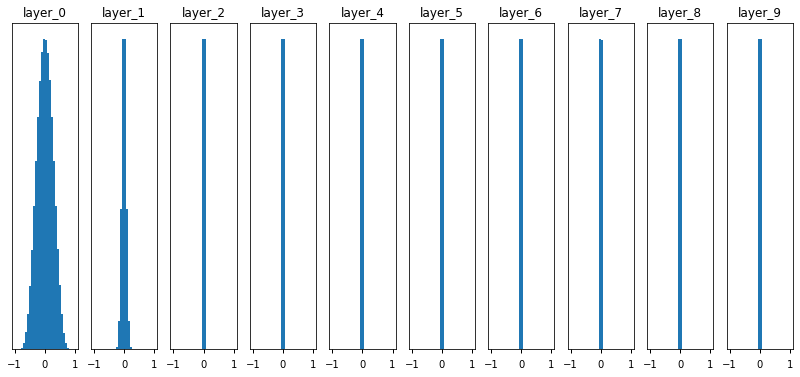

In [79]:
# 权重方差为0.01的情形
plot_layer_outs(calc_layer_output(sim_dat,0.01))

- 均值为0，但方差随着层数增加而减小，远小于0.01
- 梯度无法更新

layer_0输出均值-0.000304，标准差0.985804
layer_1输出均值0.000767，标准差0.985147
layer_2输出均值0.001974，标准差0.984583
layer_3输出均值0.001122，标准差0.984043
layer_4输出均值-0.000141，标准差0.983436
layer_5输出均值0.001050，标准差0.982512
layer_6输出均值-0.001466，标准差0.981745
layer_7输出均值0.000478，标准差0.980658
layer_8输出均值0.001337，标准差0.979448
layer_9输出均值0.000023，标准差0.978073


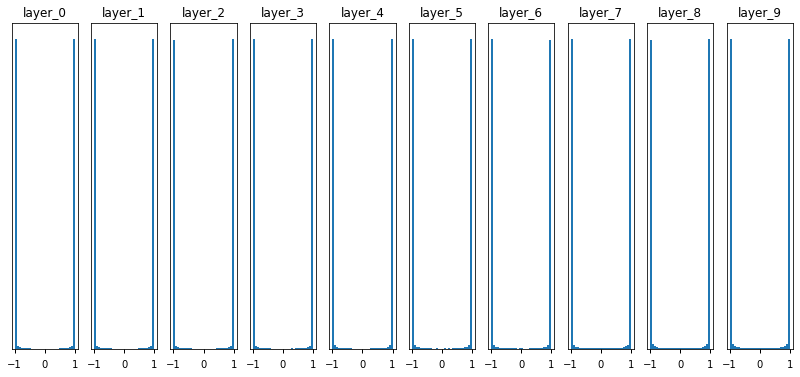

In [80]:
# 权重方差为1的情形
plot_layer_outs(calc_layer_output(sim_dat,1))

- 均值为0，权重方差接近1
- 但权重位于-1和1两个值附近，神经元饱和，导致梯度很小，无法更新

- 然而，目前对如何更好的初始化参数并没有很深入的了解
    - 可能一些初始化参数对于优化而言是有利的，但是对于泛化则是不利的

- 但是，目前达成共识的一点是：
    - 初始化参数应当打破不同神经元之间的**对称性**

- 如果具有相同激活函数的两个隐藏单元连接到相同的输入
    - 如果它们具有相同的初始参数,那么应用到确定性损失和模型的确定性学习算法将一直以相同的方式更新这两个单元。
    - 好比只有一个隐藏单元一样

### Xavier初始化

- 目前标准且实用的Xavier初始化

考虑*没有非线性*的全连接层输出（例如，隐藏变量）神经元$o_{i}$，对于该层$n_\mathrm{in}$输入$x_j$及其相关权重$w_{ij}$，输出由下式给出

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

权重$w_{ij}$都是从同一分布中独立抽取的，假设该分布具有零均值和方差$\sigma^2$。

进一步假设层$x_j$的输入也具有零均值和方差$\gamma^2$，并且它们独立于$w_{ij}$并且彼此独立。则，$o_i$的平均值和方差为，

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\
    &= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\
    &= 0
\end{aligned}
$$

$$
\begin{aligned}
    \mathrm{Var}[o_i] & = \mathrm{Var}(\sum_{j=1}^{n_\text{in}}w_{ij}x_j) \\
        & = \sum_{j=1}^{n_\mathrm{in}} \mathrm{Var}(w_{ij} x_j) \\
        & = \sum_{j=1}^{n_\mathrm{in}} \left(E[w^2_{ij}] E[x^2_j]-(E[w_{ij}]E[x_j])^2\right) \\
        & = \sum_{j=1}^{n_\mathrm{in}} \left(\left(\mathrm{Var}(w_{ij})+(E[w_{ij}])^2\right)\left(\mathrm{Var}(x_j)+(E[x_j])^2\right)-(E[w_{ij}]E[x_j])^2\right)\\
        & = \sum_{j=1}^{n_\mathrm{in}} \left(\mathrm{Var}(w_{ij})\mathrm{Var}(x_j)+\mathrm{Var}(w_{ij})(E[x_j])^2+\mathrm{Var}(x_j)(E[w_{ij}])^2\right)\\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

- $o_i$的输出方差是输入$x_i$的$n_{\text{in}}\sigma^2$倍

在反向传播中，假设输出层神经元$o_j$的梯度为$\frac{\partial J}{\partial o_j}$，且方差为$\delta^2$，则$\frac{\partial J}{\partial x_i}$的梯度的方差为，

$$
\begin{aligned}
\mathrm{Var}(\frac{\partial J}{\partial x_i})&=\mathrm{Var}(\sum_{j=1}^{n_\text{out}}\frac{\partial J}{\partial o_j}\frac{\partial o_j}{\partial x_i})=\sum_{j=1}^{n_\text{out}}\mathrm{Var}(\frac{\partial J}{\partial o_j}\frac{\partial o_j}{\partial x_i})\\
&=\sum_{j=1}^{n_\text{out}}\left(E[(\frac{\partial J}{\partial o_j}\frac{\partial o_j}{\partial x_i})^2]-(E[\frac{\partial J}{\partial o_j}\frac{\partial o_j}{\partial x_i}])^2\right)\\
&=\sum_{j=1}^{n_\text{out}}\mathrm{Var}(\frac{\partial J}{\partial o_j})\mathrm{Var}(w_{ij})\\
&=n_\text{out}\delta^2\sigma^2
\end{aligned}
$$

- $x_i$层的梯度方差是后一层$o_j$梯度方差的$n_{\text{out}}\sigma^2$倍

- 保持在传播过程中（包括前向后反向）方差不变的方法

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 或等价于 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{aligned}
\label{eq:varianceshrink}
$$

其中，$n_\mathrm{in}$和$n_\mathrm{out}$分别是输入层和输出层神经元数量

- Xavier初始化从均值为零，方差$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$的高斯分布中采样权重

- 也可以将其改为选择从均匀分布中抽取权重时的方差
- 均匀分布$U(-a, a)$的方差为$\frac{a^2}{3}$。将$\frac{a^2}{3}$代入到\eqref{eq:varianceshrink}，得到初始化值域：

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$